# Imports

In [2]:
# Std lib
from collections import namedtuple, Counter, defaultdict
from itertools import islice
import random
import glob
from pprint import pprint as pp
from shutil import rmtree
import os

# Third party
import numpy as np
import pandas as pd
from matplotlib import pyplot as pl
from pycl.pycl import *
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
from scipy import stats

# Matplotlib and pandas setup
%matplotlib inline
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200

# Prepare dataset

In [34]:
rmtree (f"extra_data/basecall/",ignore_errors=True)
mkdir (f"extra_data/basecall/")

for lab in ("WT", "KO"):
    print ("Basecall sample", lab)
    mkdir (f"extra_data/basecall/{lab}")
    cmd = f"read_fast5_basecaller.py --disable_filtering -r -t 4 -f FLO-MIN106 -k SQK-RNA001 -o fastq -q 0 -i extra_data/raw/{lab} -s extra_data/basecall/{lab}"
    print (cmd)
    bash (virtualenv="Albacore_2.3.1", cmd=cmd)
    
rmtree (f"extra_data/alignment/", ignore_errors=True)
mkdir (f"extra_data/alignment/")

for lab, fastq in (
    ("WT", "./extra_data/basecall/WT/workspace/fastq_runid_7bbcbb0d8612283496fbd59a410ba2e1b692d233.fastq"),
    ("KO", "./extra_data/basecall/KO/workspace/fastq_runid_46a6d05e0ead9cb5f524f4948c32daf0aba2ab0f.fastq")):
    mkdir (f"extra_data/alignment/{lab}")
    
    print ("Align sample", lab)
    cmd = f"minimap2 -ax map-ont -L -t 4 ./extra_data/reference/Yeast_transcriptome.fa {fastq} | samtools view -bh -F 2308 -q 30 | samtools sort -o extra_data/alignment/{lab}/reads.bam"
    print (cmd)
    bash (virtualenv="Minimap2_2.11", cmd=cmd, live="stderr")
    
    print ("Index reads sample", lab)
    cmd = f"samtools index extra_data/alignment/{lab}/reads.bam"
    print (cmd)
    bash (cmd=cmd)
    
rmtree (f"extra_data/eventalign/", ignore_errors=True)
mkdir (f"extra_data/eventalign/")

for lab, fastq in (
    ("WT", "extra_data/basecall/WT/workspace/fastq_runid_7bbcbb0d8612283496fbd59a410ba2e1b692d233.fastq"),
    ("KO", "extra_data/basecall/KO/workspace/fastq_runid_46a6d05e0ead9cb5f524f4948c32daf0aba2ab0f.fastq")):
    
    mkdir (f"./extra_data/eventalign/{lab}")
     
    # Index reads
    print ("Index sample", lab)   
    cmd = f"nanopolish index -d ./extra_data/raw/{lab} {fastq}"
    print (cmd)
    bash (virtualenv="Nanopolish_0.10.1", cmd=cmd, live="stderr")
    
    # Resquiggle
    print ("Resquiggle sample", lab)   
    bam = f"./extra_data/alignment/{lab}/reads.bam"
    ref = "./extra_data/reference/Yeast_transcriptome.fa"
    event_align_outfn = f"./extra_data/eventalign/{lab}/eventalign.tsv"
    cmd = f"nanopolish eventalign -t 4 --reads {fastq} --bam {bam} --genome {ref} --samples > {event_align_outfn}"
    print (cmd)
    bash (virtualenv="Nanopolish_0.10.1", cmd=cmd, live="stderr")
    
    # Index and collapse eventalign
    print ("Collapse sample", lab)   
    event_align_collapsed_outfn = f"./extra_data/eventalign/{lab}/eventalign_collapsed.tsv"
    cmd = f"NanopolishComp Eventalign_collapse -t 4 -i {event_align_outfn} -o {event_align_collapsed_outfn}"
    print (cmd)
    bash (virtualenv="Nanopolish_0.10.1", cmd=cmd, live="stderr")

Creating /home/aleg/Programming/nanocompore/tests/extra_data/basecall
Basecall sample WT
Creating /home/aleg/Programming/nanocompore/tests/extra_data/basecall/WT
read_fast5_basecaller.py --disable_filtering -r -t 4 -f FLO-MIN106 -k SQK-RNA001 -o fastq -q 0 -i extra_data/raw/WT -s extra_data/basecall/WT
Basecall sample KO
Creating /home/aleg/Programming/nanocompore/tests/extra_data/basecall/KO
read_fast5_basecaller.py --disable_filtering -r -t 4 -f FLO-MIN106 -k SQK-RNA001 -o fastq -q 0 -i extra_data/raw/KO -s extra_data/basecall/KO
Creating /home/aleg/Programming/nanocompore/tests/extra_data/alignment
Creating /home/aleg/Programming/nanocompore/tests/extra_data/alignment/WT
Align sample WT
minimap2 -ax map-ont -L -t 4 ./extra_data/reference/Yeast_transcriptome.fa ./extra_data/basecall/WT/workspace/fastq_runid_7bbcbb0d8612283496fbd59a410ba2e1b692d233.fastq | samtools view -bh -F 2308 -q 30 | samtools sort -o extra_data/alignment/WT/reads.bam


[M::mm_idx_gen::0.310*1.00] collected minimizers
[M::mm_idx_gen::0.425*1.50] sorted minimizers
[M::main::0.426*1.49] loaded/built the index for 6713 target sequence(s)
[M::mm_mapopt_update::0.464*1.45] mid_occ = 38
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 6713
[M::mm_idx_stat::0.484*1.43] distinct minimizers: 1527846 (95.20% are singletons); average occurrences: 1.097; average spacing: 5.416
[M::worker_pipeline::0.626*1.47] mapped 399 sequences
[M::main] Version: 2.11-r797
[M::main] CMD: minimap2 -ax map-ont -L -t 4 ./extra_data/reference/Yeast_transcriptome.fa ./extra_data/basecall/WT/workspace/fastq_runid_7bbcbb0d8612283496fbd59a410ba2e1b692d233.fastq
[M::main] Real time: 0.641 sec; CPU: 0.934 sec


Index reads sample WT
samtools index extra_data/alignment/WT/reads.bam
Creating /home/aleg/Programming/nanocompore/tests/extra_data/alignment/KO
Align sample KO
minimap2 -ax map-ont -L -t 4 ./extra_data/reference/Yeast_transcriptome.fa ./extra_data/basecall/KO/workspace/fastq_runid_46a6d05e0ead9cb5f524f4948c32daf0aba2ab0f.fastq | samtools view -bh -F 2308 -q 30 | samtools sort -o extra_data/alignment/KO/reads.bam


[M::mm_idx_gen::0.300*1.00] collected minimizers
[M::mm_idx_gen::0.399*1.51] sorted minimizers
[M::main::0.400*1.50] loaded/built the index for 6713 target sequence(s)
[M::mm_mapopt_update::0.425*1.47] mid_occ = 38
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 6713
[M::mm_idx_stat::0.443*1.45] distinct minimizers: 1527846 (95.20% are singletons); average occurrences: 1.097; average spacing: 5.416
[M::worker_pipeline::0.574*1.42] mapped 396 sequences
[M::main] Version: 2.11-r797
[M::main] CMD: minimap2 -ax map-ont -L -t 4 ./extra_data/reference/Yeast_transcriptome.fa ./extra_data/basecall/KO/workspace/fastq_runid_46a6d05e0ead9cb5f524f4948c32daf0aba2ab0f.fastq
[M::main] Real time: 0.599 sec; CPU: 0.831 sec


Index reads sample KO
samtools index extra_data/alignment/KO/reads.bam
Creating /home/aleg/Programming/nanocompore/tests/extra_data/eventalign
Creating /home/aleg/Programming/nanocompore/tests/extra_data/eventalign/WT
Index sample WT
nanopolish index -d ./extra_data/raw/WT extra_data/basecall/WT/workspace/fastq_runid_7bbcbb0d8612283496fbd59a410ba2e1b692d233.fastq


[readdb] indexing ./extra_data/raw/WT
[readdb] num reads: 400, num reads with path to fast5: 400


Resquiggle sample WT
nanopolish eventalign -t 4 --reads extra_data/basecall/WT/workspace/fastq_runid_7bbcbb0d8612283496fbd59a410ba2e1b692d233.fastq --bam ./extra_data/alignment/WT/reads.bam --genome ./extra_data/reference/Yeast_transcriptome.fa --samples > ./extra_data/eventalign/WT/eventalign.tsv


[post-run summary] total reads: 331, unparseable: 0, qc fail: 5, could not calibrate: 0, no alignment: 0, bad fast5: 0


Collapse sample WT
NanopolishComp Eventalign_collapse -t 4 -i ./extra_data/eventalign/WT/eventalign.tsv -o ./extra_data/eventalign/WT/eventalign_collapsed.tsv


[Eventalign_collapse] total reads: 326 [10.43 reads/s]


Creating /home/aleg/Programming/nanocompore/tests/extra_data/eventalign/KO
Index sample KO
nanopolish index -d ./extra_data/raw/KO extra_data/basecall/KO/workspace/fastq_runid_46a6d05e0ead9cb5f524f4948c32daf0aba2ab0f.fastq


[readdb] indexing ./extra_data/raw/KO
[readdb] num reads: 400, num reads with path to fast5: 400


Resquiggle sample KO
nanopolish eventalign -t 4 --reads extra_data/basecall/KO/workspace/fastq_runid_46a6d05e0ead9cb5f524f4948c32daf0aba2ab0f.fastq --bam ./extra_data/alignment/KO/reads.bam --genome ./extra_data/reference/Yeast_transcriptome.fa --samples > ./extra_data/eventalign/KO/eventalign.tsv


[post-run summary] total reads: 297, unparseable: 0, qc fail: 1, could not calibrate: 2, no alignment: 0, bad fast5: 0


Collapse sample KO
NanopolishComp Eventalign_collapse -t 4 -i ./extra_data/eventalign/KO/eventalign.tsv -o ./extra_data/eventalign/KO/eventalign_collapsed.tsv


[Eventalign_collapse] total reads: 295 [11.08 reads/s]


In [36]:
head ("extra_data/eventalign/KO/eventalign_collapsed.tsv")

#3	YJR094W-A
ref_pos	ref_kmer	n_events	NNNNN_events	mismatching_events	mean	std	median	mad	n_signals
144	AGAGG	1	0	0	124.20086669921875	4.266852378845215	124.2229995727539	2.720001220703125	43
145	GAGGT	2	0	0	104.7634048461914	9.09852409362793	104.70700073242188	7.548297882080078	36
146	AGGTG	1	0	0	114.68939208984375	7.070548057556152	113.5469970703125	4.895999908447266	10
147	GGTGC	2	0	0	109.89427947998047	12.621735572814941	109.19499969482422	5.439998626708984	28
148	GTGCA	2	0	0	88.36676788330078	11.42094898223877	87.0261001586914	5.372200012207031	56
149	TGCAG	1	0	0	107.35894012451172	4.821726322174072	107.49500274658203	2.720001220703125	11
150	GCAGC	2	0	0	94.35901641845703	3.5149362087249756	93.62229919433594	2.2440528869628906	48
151	CAGCT	2	0	0	107.90284729003906	6.11911153793335	110.35099792480469	5.3040008544921875	15



# Dev whitelist function

In [4]:
head ("/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv.idx")
head ("/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv")

ref_id  ref_start ref_end read_id                              kmers NNNNN_kmers mismatching_kmers missing_kmers byte_offset byte_len 
YHR055C 0         171     6f885af6-5844-476e-9e51-133dc5617dfd 169   3           0                 2             0           17657    
YHR055C 0         155     4259fc88-b781-482a-bfa9-985dc424c733 154   5           0                 1             17658       15759    
YHR055C 1         182     2b01d98a-336e-40d9-b7c4-07895b9b10a2 175   6           0                 6             33418       18185    
YHR055C 0         170     d3bcaffe-3020-4a0b-a913-254a96e92efd 167   2           0                 3             51604       17455    
YHR055C 1         172     0fd6188c-af31-43c0-bc69-3ced8dac9714 161   6           0                 10            69060       16746    
YHR055C 0         182     d978ef9e-b4b0-4998-ab41-6d9da2c50743 171   6           0                 11            85807       17857    
YHR055C 0         179     4626f47c-57a6-474a-8ab3-3c670

In [66]:
def whitelist (
    s1_fn,
    s2_fn,
    fasta_index_fn = None,
    min_cov = 10,
    max_NNNNN_kmers_freq = 0.2,
    max_mismatching_kmers_freq = 0.2,
    max_missing_kmers_freq = 0.2,
    verbose=True):

    # Read fasta index
    if verbose: print ("Read fasta index")
    ref_len_dict = _read_fasta_index (fn=fasta_index_fn)
    if verbose: print (f"\tTotal references: {len(ref_len_dict)}")

    # Create reference index for both files
    if verbose: print ("Read eventalign index files")
    ref_reads = _read_eventalign_index (s1_fn, s2_fn, max_NNNNN_kmers_freq, max_mismatching_kmers_freq, max_missing_kmers_freq)
    if verbose: print (f"\tTotal references found {len(ref_reads)}")
    
    # Intersect both samples
    if verbose: print ("Filter out references with low coverage")
    ref_reads = _select_ref (ref_reads=ref_reads, min_cov=min_cov)
    if verbose: print (f"\tTranscripts remaining after reference coverage filtering: {len(ref_reads)}")
    
    if verbose: print ("Compute coverage per reference and select intervals with high enough coverage")
    ref_interval_reads = OrderedDict ()
    for ref_id, sample_reads in ref_reads.items ():
        # Compute reference coverage
        cov_array = _compute_ref_cov (sample_reads=sample_reads, ref_len=ref_len_dict[ref_id])
        # Get coordinates of intervals with minimum coverage
        valid_interval_list = _get_valid_intervals (cov_array, min_cov)
        # Intesect reads with valid coverage for both samples
        ref_interval_reads [ref_id] = _intersect_reads_interval (valid_interval_list, sample_reads)
    
    return ref_interval_reads
        
def _read_fasta_index (fn):
    ref_len = OrderedDict ()
    with open (fn) as fp:
        for line in fp:
            ls = line.rstrip().split()
            ref_len[ls[0]] = int(ls[1])
    return ref_len

def _read_eventalign_index (s1_fn, s2_fn, max_NNNNN_kmers_freq, max_mismatching_kmers_freq, max_missing_kmers_freq):
    ref_reads = OrderedDict ()
    
    for lab, fn in ("S1", s1_fn), ("S2", s2_fn):
        with open (fn) as fp:
            # get field names from header
            header = fp.readline().rstrip().split()
            line_tuple = namedtuple("line_tuple", header)
            c = Counter ()
            for line in fp:
                ls = line.rstrip().split()
                lt = line_tuple (ls[0], int(ls[1]), int(ls[2]), ls[3], int(ls[4]), int(ls[5]) , int(ls[6]) , int(ls[7]) , int(ls[8]))
                # filter out reads with high number of problematic kmers
                if max_NNNNN_kmers_freq and lt.NNNNN_kmers/lt.kmers > max_NNNNN_kmers_freq:
                    c ["high NNNNN_kmers reads"] += 1
                elif max_mismatching_kmers_freq and lt.mismatching_kmers/lt.kmers > max_mismatching_kmers_freq:
                    c ["high mismatching_kmers reads"] += 1
                elif max_missing_kmers_freq and lt.missing_kmers/lt.kmers > max_missing_kmers_freq:
                    c ["high missing_kmers reads"] += 1
                # Save valid reads
                else:
                    if not lt.ref_id in ref_reads:
                        ref_reads[lt.ref_id] = OrderedDict ()
                    if not lab in ref_reads [lt.ref_id]:
                        ref_reads[lt.ref_id][lab] = []
                    ref_reads[lt.ref_id][lab].append (lt)
                    c ["valid reads"] += 1
        print (c)
    return ref_reads

def _select_ref (ref_reads, min_cov):
    invalid_ref = []
    for ref_id, sample_reads in ref_reads.items ():
        if len(sample_reads) < 2 or len (sample_reads["S1"]) < min_cov or len (sample_reads["S2"]) < min_cov:
            invalid_ref.append (ref_id)
    for ref_id in invalid_ref:
        del ref_reads [ref_id]
    return ref_reads

def _compute_ref_cov (sample_reads, ref_len):
    cov_array = np.zeros ((2, ref_len))
    for read in sample_reads["S1"]:
        cov_array [0][np.arange(read.ref_start, read.ref_end)] += 1
    for read in sample_reads["S2"]:
        cov_array [1][np.arange(read.ref_start, read.ref_end)] += 1
    return cov_array
        
def _get_valid_intervals (cov_array, min_cov):
    valid_cov = False
    valid_interval_list = []
    for pos, (cov1, cov2) in enumerate (cov_array.T):
        # If coverage insuficient
        if cov1 < min_cov or cov2 < min_cov:
            if valid_cov:
                valid_interval_list.append ((ref_start, ref_end))
            valid_cov = False
        # If the coverage is high enough for both samples
        else:
            if valid_cov:
                ref_end = pos
            else:
                ref_start = ref_end = pos
                valid_cov = True
    # Last valid interval exception
    if valid_cov:
        valid_interval_list.append ((ref_start, ref_end))
    
    return valid_interval_list

def _intersect_reads_interval (valid_interval_list, sample_reads):
    
    ref_interval_reads = OrderedDict ()
    for interval_start, interval_end in valid_interval_list:
        ref_interval_reads [(interval_start, interval_end)] = {"S1":[], "S2":[]}
    
    for sample_id, read_list in sample_reads.items():
        for read in read_list:
            for interval_start, interval_end in valid_interval_list: 
                if read.ref_end >= interval_start and read.ref_start <= interval_end:
                    ref_interval_reads[(interval_start, interval_end)][sample_id].append (read)
    return ref_interval_reads

In [75]:
sample1_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv.idx"
sample2_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/WT/eventalign_collapsed.tsv.idx"
fasta_index_fn = "/home/aleg/Analyses/Nanopore_yeast/references/SC_R64-1-1_transcripts.fa.fai"
w  = whitelist (sample1_fn, sample2_fn, fasta_index_fn, min_cov=5, max_NNNNN_kmers_freq=0.1, max_mismatching_kmers_freq=0.1, max_missing_kmers_freq=0.1)

Read fasta index
	Total references: 6713
Read eventalign index files
Counter({'valid reads': 11073, 'high missing_kmers reads': 927, 'high mismatching_kmers reads': 344, 'high NNNNN_kmers reads': 84})
Counter({'valid reads': 10802, 'high missing_kmers reads': 702, 'high mismatching_kmers reads': 384, 'high NNNNN_kmers reads': 84})
	Total references found 2126
Filter out references with low coverage
	Transcripts remaining after reference coverage filtering: 172
Compute coverage per reference and select intervals with high enough coverage


# Test whitelist from package

In [1]:
from nanocompore.Whitelist import Whitelist

In [6]:
sample1_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv.idx"
sample2_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/WT/eventalign_collapsed.tsv.idx"
fasta_index_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/references/SC_R64-1-1_transcripts_clean.fa.fai"
w  = Whitelist (sample1_fn, sample2_fn, fasta_index_fn,
                min_coverage=5,
                max_coverage=100,
                max_NNNNN_kmers_freq=0.1,
                max_mismatching_kmers_freq=0.1,
                max_missing_kmers_freq=0.1,
                logLevel="debug")

Initialise and checks options
Read fasta index files
	Total references: 6713
Read eventalign index files
	Sample S1 	valid reads: 11,073	high missing_kmers reads: 927	high mismatching_kmers reads: 344	high NNNNN_kmers reads: 84
	Sample S2 	valid reads: 10,802	high missing_kmers reads: 702	high mismatching_kmers reads: 384	high NNNNN_kmers reads: 84
	References found in index: 2126
Filter out references with low coverage
	positions: 181,719	S1_reads: 8,941	S2_reads: 7,889	ref_id: 172
	References remaining after reference coverage filtering: 172
Compute coverage per reference and select intervals with high enough coverage
100%|██████████| 172/172 [00:00<00:00, 523.80 References/s]
	positions: 67,876	S2_reads: 4,558	S1_reads: 2,402	intervals: 172	ref_id: 166
	References remaining after position coverage filtering: 166


In [4]:
for ref_id, ref_dict in islice(w.ref_interval_reads.items(), 10000):
    if len(ref_dict["interval_list"]) >=2: 
        jprint (ref_id, bold=True, size=150)
        pp (ref_dict["interval_list"])
        with pd.option_context("display.max_rows", 4):
            display (pd.DataFrame(ref_dict["S1"]))
            display (pd.DataFrame(ref_dict["S2"]))

[(256, 291), (328, 937)]


,ref_id,ref_start,ref_end,read_id,kmers,NNNNN_kmers,mismatching_kmers,missing_kmers,offset
0,YGR282C,68,292,f31e522b-8cb5-41ea-9fbe-919b7dfa2c22,211,13,0,13,14778454
1,YGR282C,59,836,39d52c27-39c5-4cf4-80f4-e4a33ccd5341,758,18,0,19,14792452
...,...,...,...,...,...,...,...,...,...
21,YGR282C,785,938,2e99fc24-4f5e-4074-b888-f52e7ec8fc57,144,6,0,9,15379603
22,YGR282C,800,930,abbd6905-183f-41a3-b69d-ed051c24e2cc,128,2,0,3,15389484


,ref_id,ref_start,ref_end,read_id,kmers,NNNNN_kmers,mismatching_kmers,missing_kmers,offset
0,YGR282C,1,938,b7e6ba90-eda3-49b1-9901-8ce7b82607f6,909,25,0,28,35886978
1,YGR282C,1,931,ed294476-9d30-4db3-9998-08e040e2d02e,884,30,0,46,35948292
...,...,...,...,...,...,...,...,...,...
14,YGR282C,49,938,e3ef4d16-352d-4563-a577-5de85b078ca4,842,32,0,47,36622513
15,YGR282C,642,938,09cbcc5a-7e53-49d8-9267-5e5395bc99ed,278,12,0,18,36679904


[(428, 479), (515, 752)]


,ref_id,ref_start,ref_end,read_id,kmers,NNNNN_kmers,mismatching_kmers,missing_kmers,offset
0,YGR214W,0,755,ad3944d6-56af-4588-adb6-b092977063f4,725,18,0,30,17215061
1,YGR214W,283,755,4c537718-3cf8-4f5e-b5ad-6a27a91b5294,446,11,0,26,17263729
...,...,...,...,...,...,...,...,...,...
5,YGR214W,515,753,f85c6169-a90c-41c7-a038-1192c79967da,231,5,0,7,17408168
6,YGR214W,591,755,f057fbd9-5c54-4aa1-bde0-1965cb0208b5,157,6,0,7,17423948


,ref_id,ref_start,ref_end,read_id,kmers,NNNNN_kmers,mismatching_kmers,missing_kmers,offset
0,YGR214W,0,755,48c7bee5-e69f-42b6-9053-85b2d8d2795e,717,28,0,38,40490944
1,YGR214W,0,755,16634c3c-9ee3-4854-bd80-b874a8413f00,708,27,0,47,40539366
...,...,...,...,...,...,...,...,...,...
7,YGR214W,7,750,dd9abe84-e5eb-4c4b-b5e5-d098219093b2,709,18,0,34,41040582
8,YGR214W,342,753,4141b626-45b2-4aad-a08a-accccacc6414,398,8,0,13,41097036


[(214, 226), (270, 658)]


,ref_id,ref_start,ref_end,read_id,kmers,NNNNN_kmers,mismatching_kmers,missing_kmers,offset
0,YLR075W,7,227,57c5becb-ead3-4b95-8e2a-ec88e70d1534,210,8,0,10,341221635
1,YLR075W,1,659,0bfc5c11-8e2a-4ed5-be52-9982814f1852,621,21,0,37,341257251
...,...,...,...,...,...,...,...,...,...
5,YLR075W,368,660,5338823f-a6ba-4478-b30f-7f91764e63a6,269,11,0,25,341414441
6,YLR075W,270,659,1c98b629-0b93-49cc-9da3-d50a598e85ce,376,10,0,13,341438510


,ref_id,ref_start,ref_end,read_id,kmers,NNNNN_kmers,mismatching_kmers,missing_kmers,offset
0,YLR075W,1,662,dcbeeae4-dd6a-476a-b6c9-4dcddb5c6748,638,18,0,23,323565964
1,YLR075W,2,660,7fda2283-91ee-4215-adba-74b6450953b0,622,27,0,36,323661395
...,...,...,...,...,...,...,...,...,...
41,YLR075W,322,662,8b66f421-f024-4737-bd01-6639a95de68f,323,11,0,19,325336853
42,YLR075W,310,662,1378bfc9-f274-4a94-a74f-d1f7bae54fe1,325,19,0,27,325358844


[(87, 165), (195, 353)]


,ref_id,ref_start,ref_end,read_id,kmers,NNNNN_kmers,mismatching_kmers,missing_kmers,offset
0,YHL015W,45,354,2b3df7c1-b09b-4128-b56b-f16f0b8bcde6,288,13,0,21,360206328
1,YHL015W,1,362,0c081d68-b882-42db-96b1-33493db09aeb,354,8,0,7,360225404
...,...,...,...,...,...,...,...,...,...
5,YHL015W,195,361,8923c6fc-5459-4dfa-a109-c55305d95394,163,4,0,3,360293660
6,YHL015W,87,362,1d72f4c9-6f33-40f6-8868-e38756cbc0ea,262,8,0,14,360304815


,ref_id,ref_start,ref_end,read_id,kmers,NNNNN_kmers,mismatching_kmers,missing_kmers,offset
0,YHL015W,1,362,d41329eb-369e-4986-a063-45d5b4807c61,341,12,0,20,372527796
1,YHL015W,0,362,a3bc7db5-6da5-430e-a715-916fffcaa386,345,12,0,17,372550850
...,...,...,...,...,...,...,...,...,...
17,YHL015W,203,362,d6b8adae-3289-43f2-84a4-9e9d597f1d1f,153,3,0,7,372998791
18,YHL015W,15,362,92e8ccab-89fd-41ee-b331-cdaabec893fb,320,15,0,27,373009289


[(4809, 4912), (4949, 5244)]


,ref_id,ref_start,ref_end,read_id,kmers,NNNNN_kmers,mismatching_kmers,missing_kmers,offset
0,YER138C,3692,4276,384d007f-2a40-479c-9475-d137c600a04b,542,18,0,42,384758032
1,YER138C,1561,2050,946f84b1-bf7d-4843-8b3b-870b7622ba2d,450,22,0,39,384795087
...,...,...,...,...,...,...,...,...,...
7,YER138C,4949,5264,fc53b0a7-5bbe-4b35-9244-cd6df7ce4267,302,12,0,18,385070463
8,YER138C,4809,5264,21abc37e-9d1f-4838-b8d3-9537d6a12fa6,440,12,0,15,385105908


,ref_id,ref_start,ref_end,read_id,kmers,NNNNN_kmers,mismatching_kmers,missing_kmers,offset
0,YER138C,3039,5260,6452c5d7-c5fc-4fa7-9019-e9add22558eb,2055,97,0,166,399062802
1,YER138C,1822,4443,67705ada-e198-4e0c-8b7d-003f66daf460,2540,61,0,81,399203633
...,...,...,...,...,...,...,...,...,...
5,YER138C,5033,5264,22e6a767-bcd0-4a02-b832-871cbc972779,218,5,0,13,399716252
6,YER138C,3536,5264,7f9ccf05-8579-4327-9eb8-d51507f11de5,1659,49,0,69,399731355


[(4809, 4912), (5038, 5102)]


,ref_id,ref_start,ref_end,read_id,kmers,NNNNN_kmers,mismatching_kmers,missing_kmers,offset
0,YOL103W-B,1406,1995,6077e2ef-cf62-424b-b115-e6de3d79584a,571,15,0,18,405557881
1,YOL103W-B,3692,4276,384d007f-2a40-479c-9475-d137c600a04b,542,18,0,42,405716166
...,...,...,...,...,...,...,...,...,...
7,YOL103W-B,4809,5264,21abc37e-9d1f-4838-b8d3-9537d6a12fa6,442,12,0,13,406036594
8,YOL103W-B,5038,5259,a52a2c1b-a567-484b-935b-c44ffc2f42bf,209,9,0,15,406066990


,ref_id,ref_start,ref_end,read_id,kmers,NNNNN_kmers,mismatching_kmers,missing_kmers,offset
0,YOL103W-B,3039,5260,6452c5d7-c5fc-4fa7-9019-e9add22558eb,2059,97,0,162,460050822
1,YOL103W-B,1822,4443,67705ada-e198-4e0c-8b7d-003f66daf460,2540,61,0,81,460191924
...,...,...,...,...,...,...,...,...,...
6,YOL103W-B,3536,5264,7f9ccf05-8579-4327-9eb8-d51507f11de5,1655,49,0,73,460749756
7,YOL103W-B,5098,5257,e2253b88-3291-4085-8e6a-6d473aba8b61,149,7,0,10,460893434


In [11]:
s1_index_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv.idx"
s2_index_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/WT/eventalign_collapsed.tsv.idx"
fasta_index_fn = "/home/aleg/Analyses/Nanopore_yeast/references/SC_R64-1-1_transcripts.fa.fai"

w  = Whitelist (s1_index_fn, s2_index_fn, fasta_index_fn, min_coverage=15, max_NNNNN_kmers_freq=0.1, max_mismatching_kmers_freq=0.1, max_missing_kmers_freq=0.1, logLevel="debug")

Initialise and checks options
Read fasta index files
	Total references: 6713
Read eventalign index files
	Sample S1 	valid reads: 11,073	high missing_kmers reads: 927	high mismatching_kmers reads: 344	high NNNNN_kmers reads: 84
	Sample S2 	valid reads: 10,802	high missing_kmers reads: 702	high mismatching_kmers reads: 384	high NNNNN_kmers reads: 84
	References found in index: 2126
Filter out references with low coverage
	positions: 39,312	S1_reads: 7,959	S2_reads: 5,934	ref_id: 50
	References remaining after reference coverage filtering: 50
Compute coverage per reference and select intervals with high enough coverage
100%|██████████| 50/50 [00:00<00:00, 299.82 References/s]
	positions: 15,054	S1_reads: 7,841	S2_reads: 5,659	intervals: 47	ref_id: 45
	References remaining after position coverage filtering: 45


In [9]:
w.ref_id_list[:10]

['YKL096W-A',
 'YLR029C',
 'YLR249W',
 'YKR059W',
 'YOR369C',
 'YJR145C',
 'YKL006W',
 'YOL120C',
 'YNL069C',
 'YGR282C']

In [13]:
w.to_bed ("/home/aleg/Analyses/RNA_Yeast_TRM5/test/whitelist.bed")
head ("/home/aleg/Analyses/RNA_Yeast_TRM5/test/whitelist.bed")

YKL096W-A 10  272  
YLR029C   388 556  
YKR059W   878 1177 
YOR369C   21  420  
YJR145C   530 776  
YKL006W   176 230  
YKL006W   245 377  
YOL120C   238 534  
YGR282C   643 910  
YHR141C   12  311  



# nanopolish eventalign parser

In [15]:
from nanocompore.helper_lib import mytqdm
from nanocompore.Whitelist import Whitelist

class SampComp (object):
    def __init__ (self, s1_fn, s2_fn, whitelist):
        self.__whitelist = whitelist
        self.__s1_fn = s1_fn
        self.__s2_fn = s2_fn
        self.__logLevel = "info"

    def read_eventalign (self):
        
          with open (self.__s1_fn) as s1_fp, open (self.__s2_fn) as s2_fp: # Open only once
                pbar = mytqdm (total = len(self.__whitelist), unit=" References", disable=self.__logLevel == "warning")
                for ref_id, ref_dict in self.__whitelist:
                    pbar.update ()
                    
                    # Init empty dict for all positions in valid intervals
                    position_dict = OrderedDict ()
                    for interval_start, interval_end in ref_dict["interval_list"]:
                        for i in range (interval_start, interval_end+1):
                            position_dict[i] = {"S1_mean":[], "S1_dwell":[], "S2_mean":[], "S2_dwell":[]}

                    # Parse S1 and S2 reads data and add to mean and dwell time per position
                    for lab, fp in (("S1", s1_fp), ("S2", s2_fp)):
                        for read in ref_dict[lab]:

                            # Move to read save read data chunk and reset file pointer 
                            fp.seek (read.byte_offset)
                            read_lines = fp.read (read.byte_len)
                            fp.seek (0)
                    
                            # Check if positions are in the ones found in the whitelist intervals 
                            for line in read_lines.split("\n")[2:]:
                                ls = line.split("\t")
                                ref_pos = int(ls[0])
                                
                                # Append mean value and dwell time
                                if ref_pos in position_dict:
                                    position_dict[ref_pos][lab+"_mean"].append(float(ls[8]))
                                    position_dict[ref_pos][lab+"_dwell"].append(int(ls[9]))
                    
                    yield ((ref_id, position_dict))


# Test SampComp

In [25]:
# -*- coding: utf-8 -*-

#~~~~~~~~~~~~~~IMPORTS~~~~~~~~~~~~~~#
# Std lib
import logging
from collections import defaultdict, OrderedDict, namedtuple, Counter
import os
import shelve
import multiprocessing as mp

# Third party
import numpy as np

# Local package
#from nanocompore.txCompare import txCompare
from nanocompore.helper_lib import mkdir, access_file, mytqdm
from nanocompore.Whitelist import Whitelist
from nanocompore.NanocomporeError import NanocomporeError

# Logger setup
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger(__name__)
logLevel_dict = {"debug":logging.DEBUG, "info":logging.INFO, "warning":logging.WARNING}

#~~~~~~~~~~~~~~MAIN FUNCTION~~~~~~~~~~~~~~#
class SampComp (object):
    """ Produce useful results. => Thanks Tommaso ! That's a very *useful* comment :P """

    def __init__(self,
        s1_fn,
        s2_fn,
        whitelist,
        output_db_fn,
        padj_threshold = 0.1,
        comparison_method = "kmean",
        nthreads = 4,
        logLevel = "info",):

        """
        Main routine that starts readers and consumers
            s1_fn: path to a nanopolish eventalign collapsed file corresponding to sample 1
            s2_fn: path to a nanopolish eventalign collapsed file corresponding to sample 2
            outfolder: path to folder where to save output
            nthreads: number of consumer threads
            whitelist_dict: Dictionnary generated by nanocopore whitelist function
        """
        # Set logging level
        logger.setLevel (logLevel_dict.get (logLevel, logging.WARNING))
        logger.info ("Initialise and checks options")
        
        # Check args
        if not isinstance (whitelist, Whitelist):
            raise NanocomporeError("Whitelist is not valid")
        for fn in (s1_fn, s2_fn):
            access_file (fn)
        if nthreads < 3:
            raise NanocomporeError("Number of threads not valid")
        #mkdir (outfolder)    
        
        # Save private args
        self.__logLevel = logLevel
        self.__padj_threshold = padj_threshold
        self.__whitelist = whitelist
        self.__s1_fn = s1_fn
        self.__s2_fn = s2_fn
        self.__output_db_fn = output_db_fn
        self.__nthreads = nthreads-2
        
        logger.info ("Start data processing")
        
        # Init Multiprocessing variables
        in_q = mp.Queue (maxsize = 1000)
        out_q = mp.Queue (maxsize = 1000)

        # Define processes
        ps_list = []
        ps_list.append (mp.Process (target=self._read_eventalign_files, args=(in_q,)))
        for i in range (self.__nthreads):
            ps_list.append (mp.Process (target=self._process_references, args=(in_q, out_q)))
        ps_list.append (mp.Process (target=self._write_output, args=(out_q,)))

        # Start processes and block until done
        try:
            for ps in ps_list:
                ps.start ()
            for ps in ps_list:
                ps.join ()

        # Kill processes if early stop
        except (BrokenPipeError, KeyboardInterrupt) as E:
            if self.verbose: stderr_print ("Early stop. Kill processes\n")
            for ps in ps_list:
                ps.terminate ()
    
    def _read_eventalign_files (self, in_q):      
        # Add refid to inqueue to dispatch the data among the workers
        with open (self.__s1_fn) as s1_fp, open (self.__s2_fn) as s2_fp:                
            for ref_id, ref_dict in self.__whitelist:

                # Init empty dict for all positions in valid intervals
                position_dict = OrderedDict ()
                for interval_start, interval_end in ref_dict["interval_list"]:
                    for i in range (interval_start, interval_end+1):
                        position_dict[i] = {"S1_mean":[], "S1_dwell":[], "S2_mean":[], "S2_dwell":[]}

                # Parse S1 and S2 reads data and add to mean and dwell time per position
                for lab, fp in (("S1", s1_fp), ("S2", s2_fp)):
                    for read in ref_dict[lab]:

                        # Move to read save read data chunk and reset file pointer 
                        fp.seek (read.byte_offset)
                        read_lines = fp.read (read.byte_len)
                        fp.seek (0)

                        # Check if positions are in the ones found in the whitelist intervals 
                        for line in read_lines.split("\n")[2:]:
                            ls = line.split("\t")
                            ref_pos = int(ls[0])

                            # Append mean value and dwell time
                            if ref_pos in position_dict:
                                position_dict[ref_pos][lab+"_mean"].append(float(ls[8]))
                                position_dict[ref_pos][lab+"_dwell"].append(int(ls[9]))
                    
                in_q.put ((ref_id, position_dict))
                    
        # Add 1 poison pill for each worker thread
        for i in range (self.__nthreads):
            in_q.put (None)
    
    def _process_references (self, in_q, out_q): 
        # Consumme ref_id until a poison pill is found
        for ref_id, position_dict in iter (in_q.get, None):
            # Do stats with position_dict
            ####### position_dict = tx_compare (padj_threshold, comparison_method) ## Add p-value per position to the position_dict. #######
            # Add the current read details to queue
            out_q.put ((ref_id, position_dict))
        
        # Add poison pill in queues
        out_q.put (None)
    
    def _write_output (self, out_q):
        
        with shelve.open (self.__output_db_fn) as db:
            # Iterate over the counter queue and process items until all poison pills are found
            pbar = tqdm (total = len(self.__whitelist), unit=" Processed References", disable=self.__logLevel=="warning")
            for _ in range (self.__nthreads):
                for ref_id, stat_dict in iter (out_q.get, None):
                    # Write results in a shelve db to get around multithreaded isolation
                    db [ref_id] = stat_dict 
                    pbar.update ()
            pbar.close()
                    

# Dev TxComp module

In [83]:
from nanocompore.SampComp import SampComp

s = SampComp (
    max_NNNNN_freq=0.1,
    max_mismatching_freq=0.1,
    max_missing_freq=0.1,
    s1_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv",
    s2_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/WT/eventalign_collapsed.tsv",
    output_db_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/test/out.db",
    fasta_index_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/references/SC_R64-1-1_transcripts_clean.fa.fai",
    nthreads=8,
    min_coverage=25,
    logLevel = "debug")

Initialise and checks options
Initialise and checks options
Read fasta index files
	Total references: 6713
Read eventalign index files
	Sample S1 	valid reads: 11,073	high missing_kmers reads: 927	high mismatching_kmers reads: 344	high NNNNN_kmers reads: 84
	Sample S2 	valid reads: 10,802	high missing_kmers reads: 702	high mismatching_kmers reads: 384	high NNNNN_kmers reads: 84
	References found in index: 2126
Filter out references with low coverage
	positions: 13,023	S1_reads: 7,301	S2_reads: 4,337	ref_id: 13
	References remaining after reference coverage filtering: 13
Compute coverage per reference and select intervals with high enough coverage
100%|██████████| 13/13 [00:00<00:00, 100.52 References/s]
	S1_reads: 7,267	positions: 6,012	S2_reads: 4,332	intervals: 13	ref_id: 13
	References remaining after position coverage filtering: 13
Start data processing
100%|██████████| 13/13 [00:27<00:00,  7.27s/ Processed References]


In [93]:
from scipy.stats import mannwhitneyu, ks_2samp, ttest_ind, combine_pvalues
import random

def paired_test (ref_pos_dict, method="mann_whitney", sequence_context=0, min_coverage=20):

    # Predefine stat test
    if method in ["mann_whitney", "MW"]:
        stat_test = mannwhitneyu
    elif method in ["kolmogorov_smirnov", "KS"]:
        stat_test = ks_2samp
    elif method in ["t_test", "TT"]:
        stat_test = ttest_ind
    else:
        raise NanocomporeError ("Invalid statistical method name (MW, KS, ttest)")
    
    # Perform pair comparison position per position if coverage is sufficient    
    res_dict = OrderedDict ()
    
    for pos, pos_dict in tqdm (ref_pos_dict.items()):
        if pos_dict["S1_count"] >= min_coverage and pos_dict["S2_count"] >= min_coverage:
            res_dict[pos] = OrderedDict ()
            
            # Number of batch tests dependent on coverage
            n_batch = (max((pos_dict["S1_count"], pos_dict["S2_count"]))*5)//min_coverage
            
            # Compute 
            for var in ("median", "dwell"):
                s1_data = pos_dict["S1_"+var]
                s2_data = pos_dict["S2_"+var]
                pval_array = np.empty (shape=n_batch, dtype=np.float64)
                for i in range (n_batch):
                    pval_array[i] = stat_test (np.random.choice (s1_data, min_coverage), np.random.choice (s2_data, min_coverage))[1]
                res_dict[pos][var] = np.mean (pval_array)

    if not sequence_context:
        return res_dict
    
    # If a sequence context is required combine adjacent pvalues with fishers method when possible
    else:
        res_dict_combined = OrderedDict()

        for mid_pos in res_dict.keys():
            pval_median_list = []
            pval_dwell_list = []

            try:
                for pos in range (mid_pos-sequence_context, mid_pos+sequence_context+1):
                    pval_median_list.append (res_dict [pos]["median"])
                    pval_dwell_list.append (res_dict [pos]["dwell"])

                res_dict_combined [mid_pos] = OrderedDict()
                res_dict_combined [mid_pos]["median"] = stats.combine_pvalues (pval_median_list, method='fisher') [1]
                res_dict_combined [mid_pos]["dwell"] = stats.combine_pvalues (pval_dwell_list, method='fisher') [1]
            
            # In case at least one of the adjacent position is missing
            except KeyError:
                pass

        return res_dict_combined

mann_whitney

100%|██████████| 412/412 [00:01<00:00, 250.33it/s] 


kolmogorov_smirnov

100%|██████████| 412/412 [00:00<00:00, 437.48it/s] 

t_test


100%|██████████| 412/412 [00:01<00:00, 250.12it/s] 


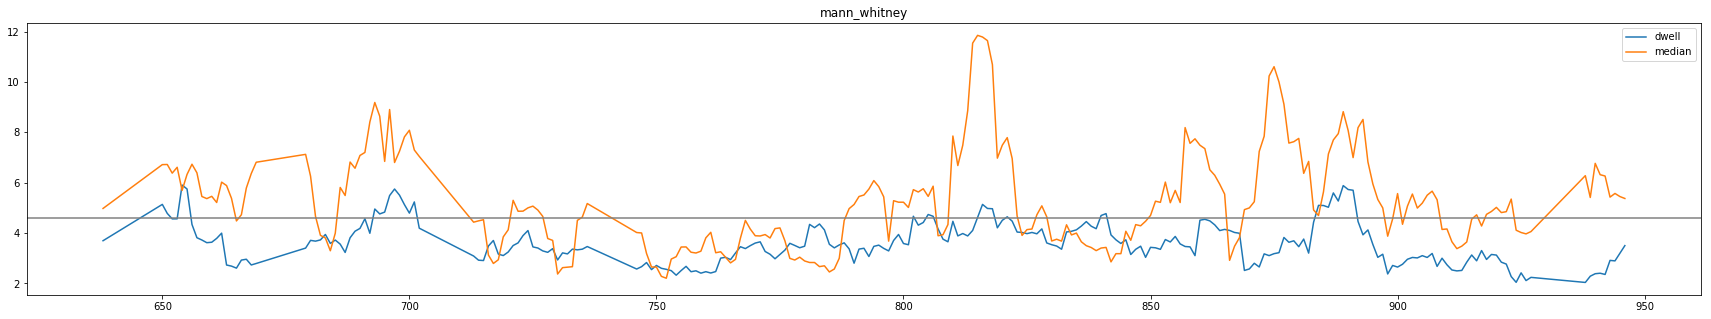

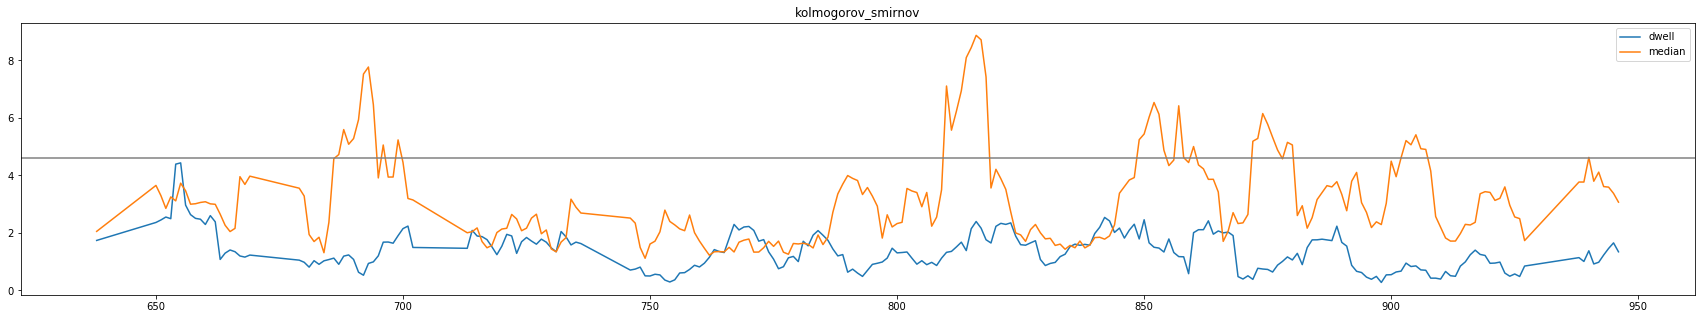

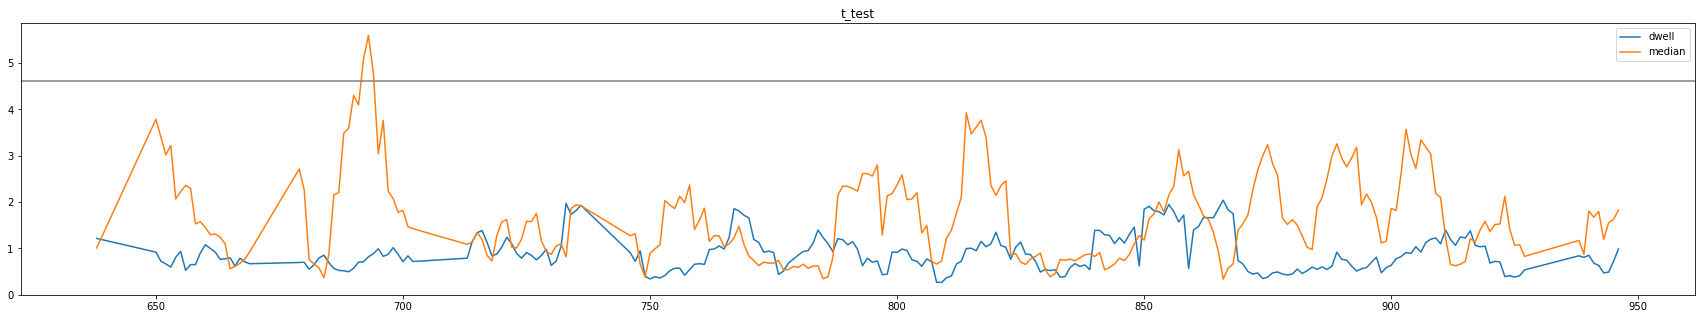

In [94]:
ref_dict = s["YMR116C"]
sig_lim = -np.log (0.01)

for method in ("mann_whitney", "kolmogorov_smirnov", "t_test"):
    stdout_print (method)
    res_dict = paired_test (ref_dict, method=method, sequence_context=4, min_coverage=30)
    fig, ax = pl.subplots (figsize=(30,5))
    df = -np.log (pd.DataFrame (res_dict)).transpose()
    _ = df.plot(ax=ax)
    _ = ax.axhline (sig_lim, c="gray")
    _ = ax.set_title (method)

YMR116C

100%|██████████| 543/543 [00:01<00:00, 402.51it/s] 


YOR369C

100%|██████████| 261/261 [00:00<00:00, 723538.23it/s]


YBR118W

100%|██████████| 641/641 [00:05<00:00, 113.81it/s] 


YPR080W

100%|██████████| 641/641 [00:05<00:00, 117.55it/s]


YLR110C

100%|██████████| 398/398 [00:03<00:00, 112.56it/s]


YGL135W

100%|██████████| 364/364 [00:00<00:00, 3604.47it/s]

YLR044C


100%|██████████| 350/350 [00:01<00:00, 284.04it/s] 


YJR009C

100%|██████████| 435/435 [00:04<00:00, 107.71it/s]


YGR254W

100%|██████████| 944/944 [00:14<00:00, 63.73it/s] 


YGR192C

100%|██████████| 541/541 [00:11<00:00, 47.94it/s]


YKL060C

100%|██████████| 483/483 [00:02<00:00, 226.60it/s]


YPL220W

100%|██████████| 364/364 [00:00<00:00, 3869.01it/s]

YDR524C-B


100%|██████████| 195/195 [00:00<00:00, 343.37it/s]


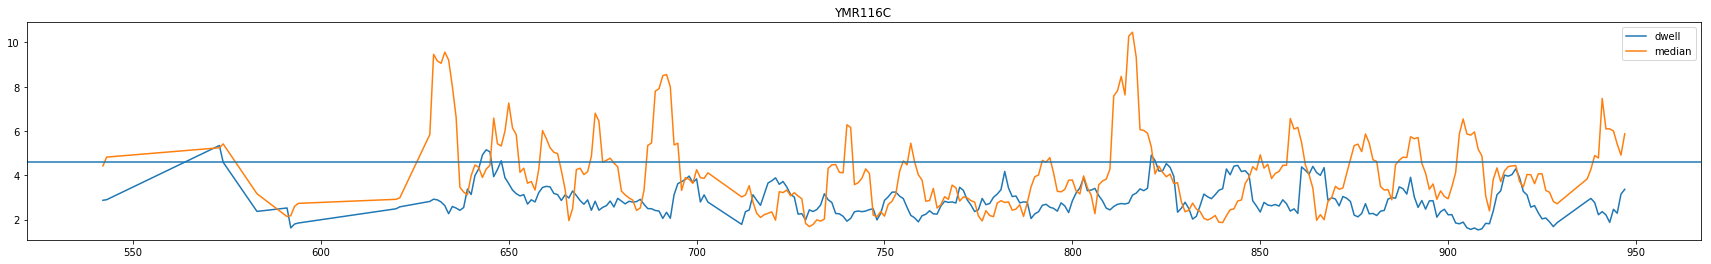

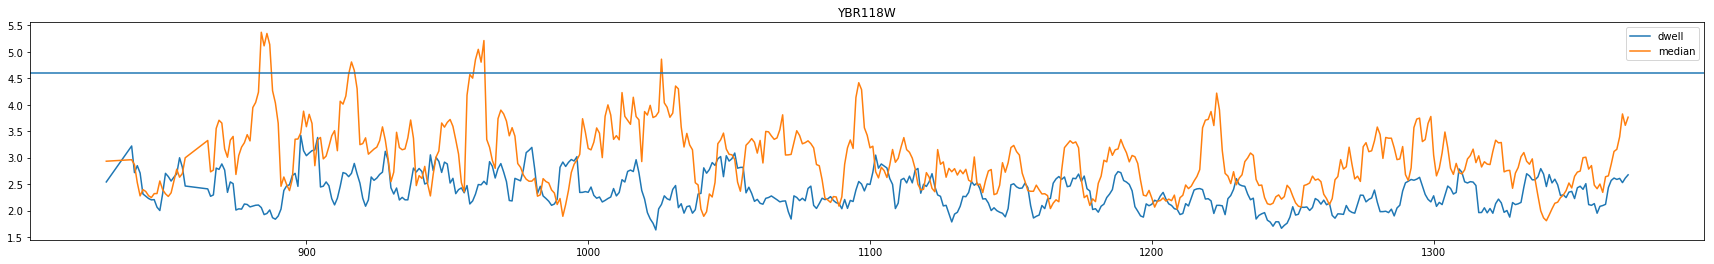

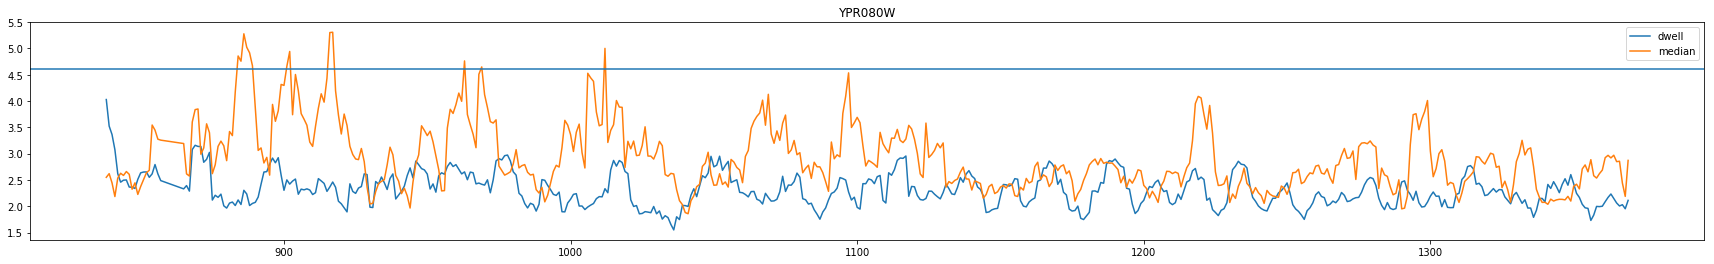

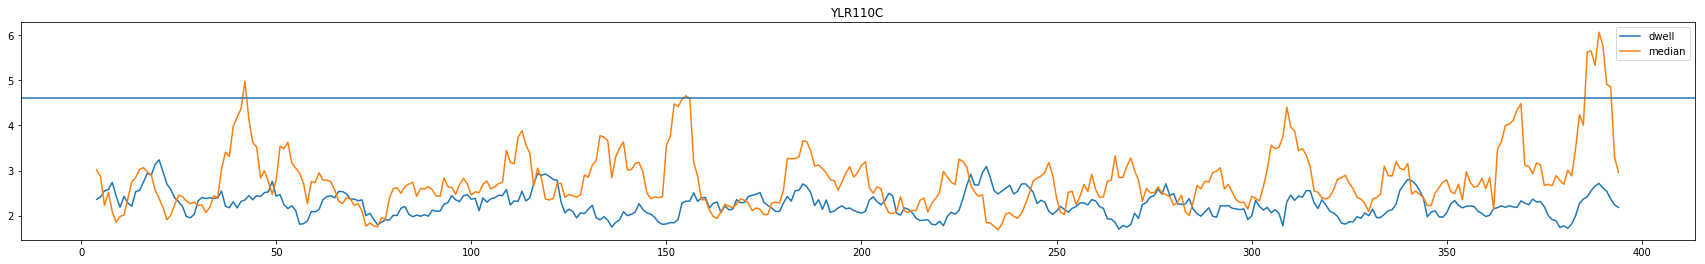

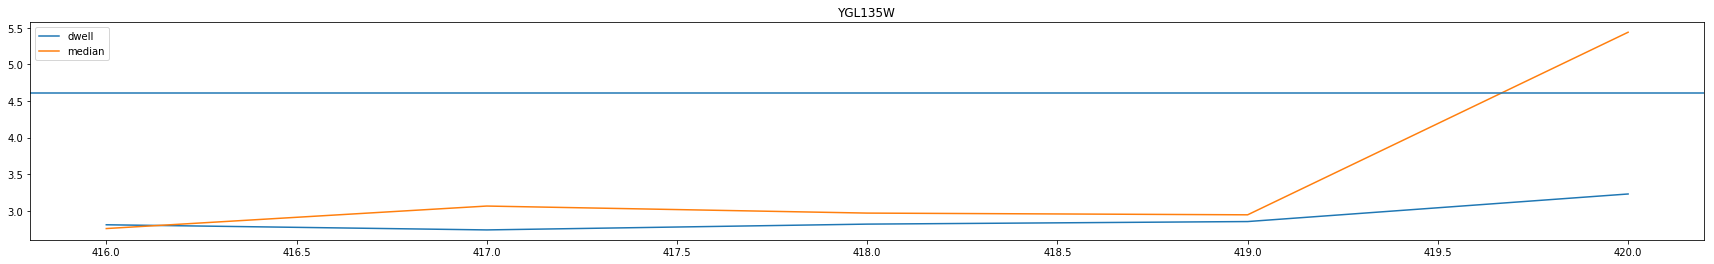

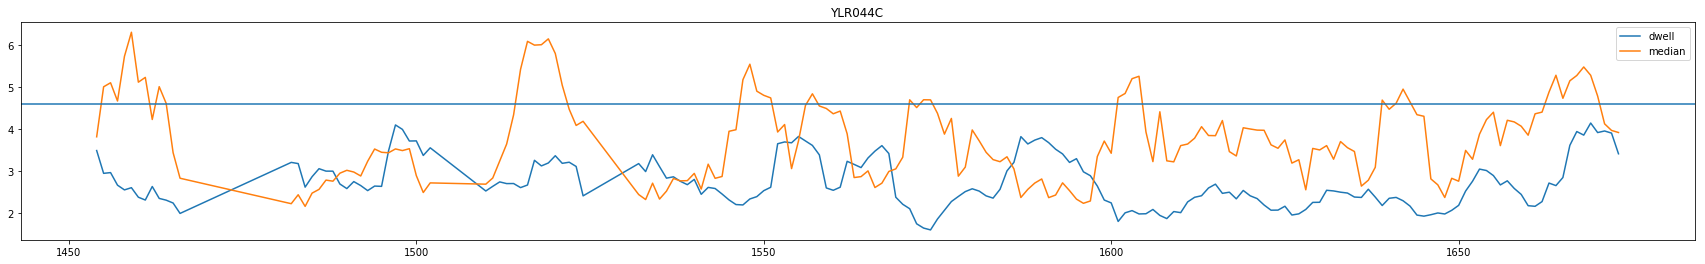

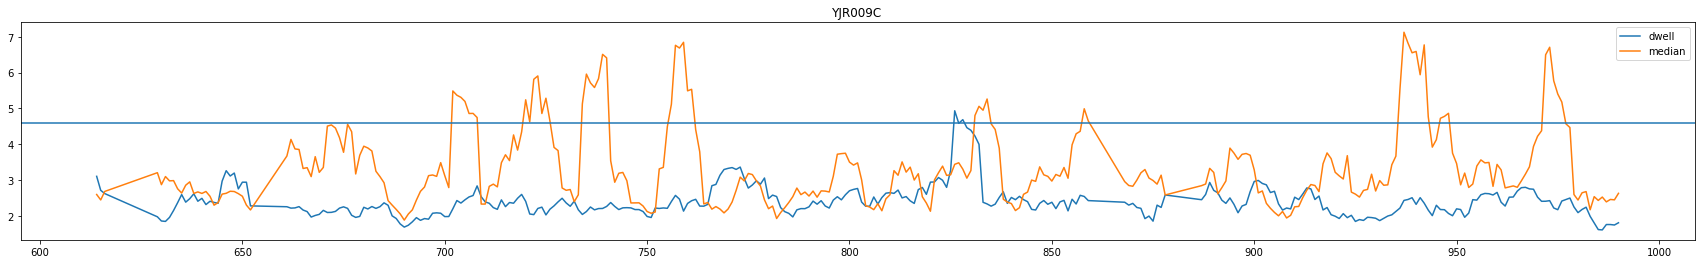

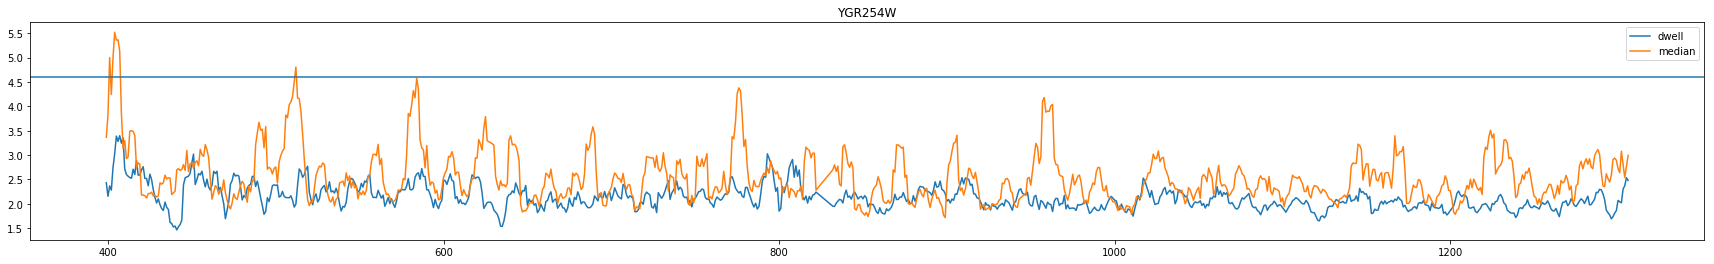

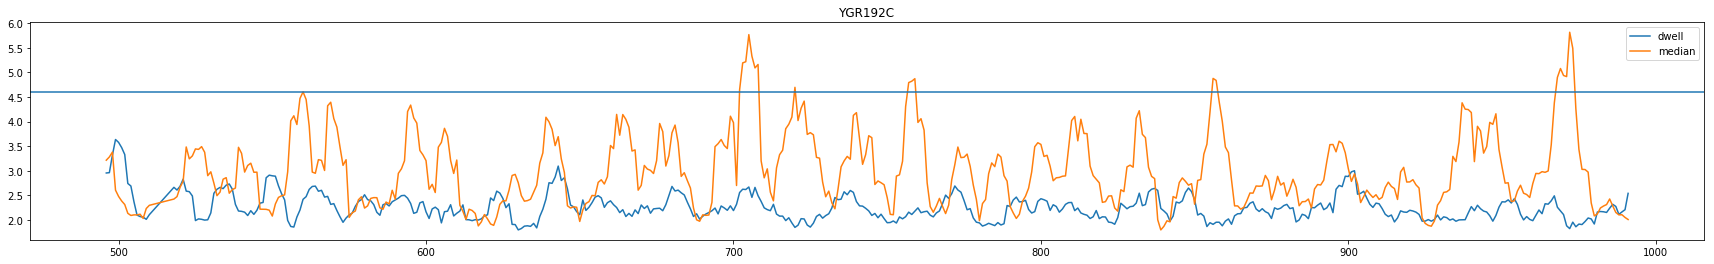

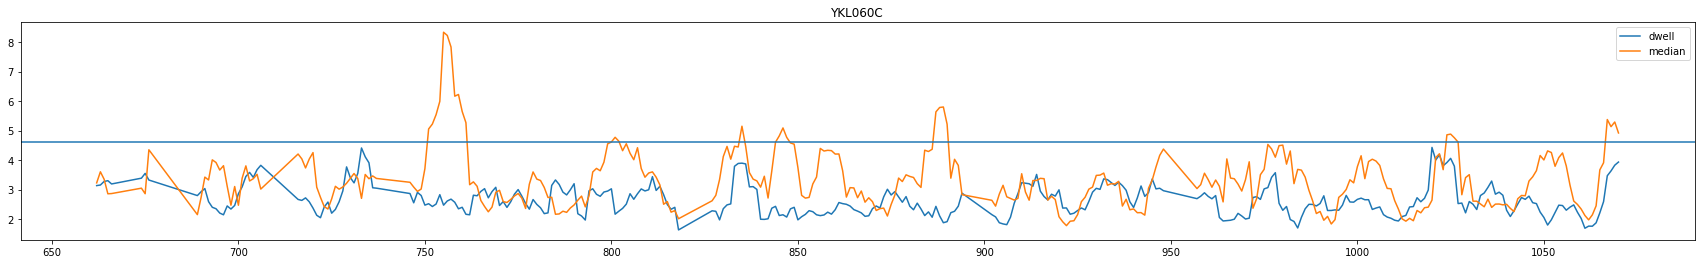

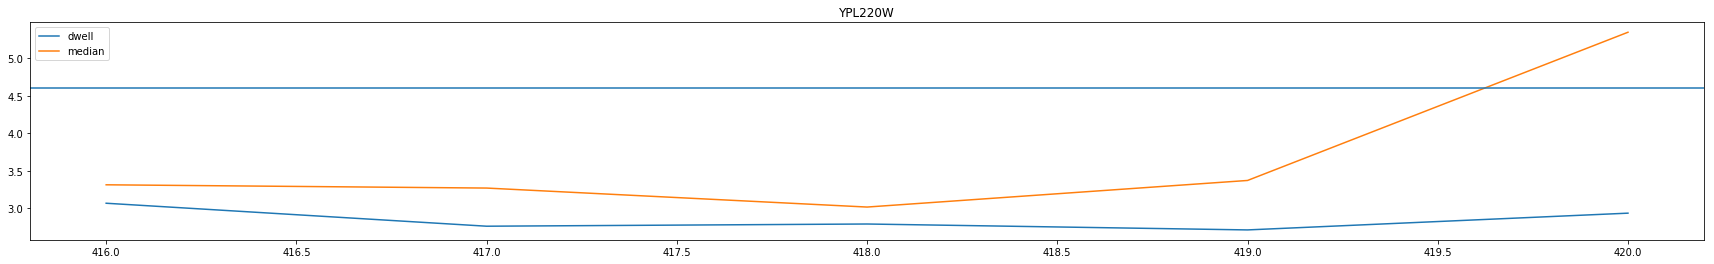

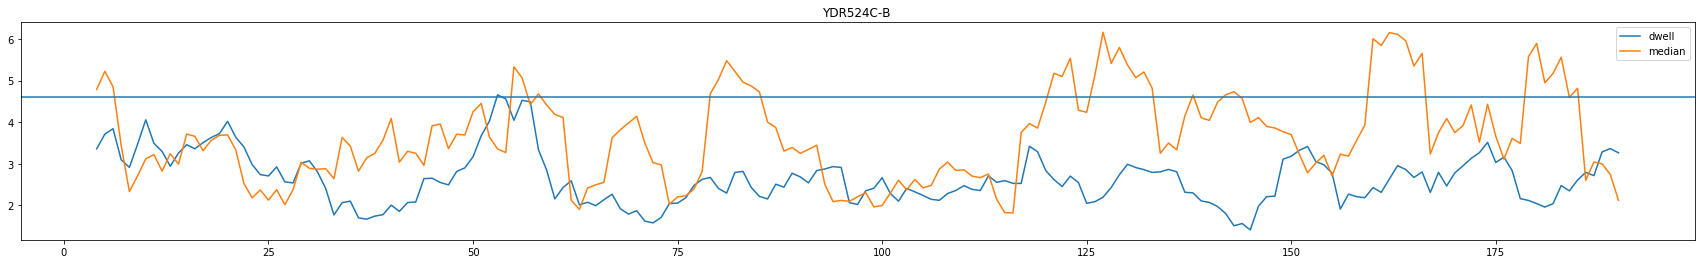

In [82]:
lim = -np.log(0.01)

for ref_id, ref_dict in s:
    if ref_id == "YHR174W":
        continue
    stdout_print (ref_id)
    res_dict = paired_test (ref_dict, method="mann_whitney", sequence_context=3, min_coverage=25)
    
    if res_dict:
        fig, ax = pl.subplots (figsize=(30,4))
        df = -np.log (pd.DataFrame(res_dict)).transpose()
        _ = df.plot (ax=ax)
        _ = ax.axhline (lim)
        _ = ax.set_title (ref_id)

# Test Package

In [3]:
from nanocompore.SampComp import SampComp

s = SampComp (
    max_NNNNN_freq=0.1,
    max_mismatching_freq=0.1,
    max_missing_freq=0.1,
    s1_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv",
    s2_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/WT/eventalign_collapsed.tsv",
    output_db_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/test/out.db",
    fasta_index_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/references/SC_R64-1-1_transcripts_clean.fa.fai",
    nthreads=8,
    min_coverage=30,
    comparison_method = "t_test",
    logLevel = "debug")

Initialise and checks options
Initialise and checks options
Read fasta index files
	Total references: 6713
Read eventalign index files
	Sample S1 	valid reads: 11,073	high missing_kmers reads: 927	high mismatching_kmers reads: 344	high NNNNN_kmers reads: 84
	Sample S2 	valid reads: 10,802	high missing_kmers reads: 702	high mismatching_kmers reads: 384	high NNNNN_kmers reads: 84
	References found in index: 2126
Filter out references with low coverage
	positions: 11,715	S1_reads: 7,251	S2_reads: 4,203	ref_id: 11
	References remaining after reference coverage filtering: 11
Compute coverage per reference and select intervals with high enough coverage
100%|██████████| 11/11 [00:00<00:00, 113.89 References/s]
	S1_reads: 7,216	positions: 5,543	S2_reads: 4,198	intervals: 11	ref_id: 11
	References remaining after position coverage filtering: 11
Start data processing
100%|██████████| 11/11 [06:48<00:00, 116.84s/ Processed References]


In [4]:
s.ref_id_list

['YMR116C',
 'YBR118W',
 'YPR080W',
 'YLR110C',
 'YLR044C',
 'YJR009C',
 'YGR254W',
 'YGR192C',
 'YHR174W',
 'YKL060C',
 'YDR524C-B']

YMR116CYBR118WYPR080WYLR110CYLR044CYJR009CYGR254WYGR192CYHR174WYKL060CYDR524C-B

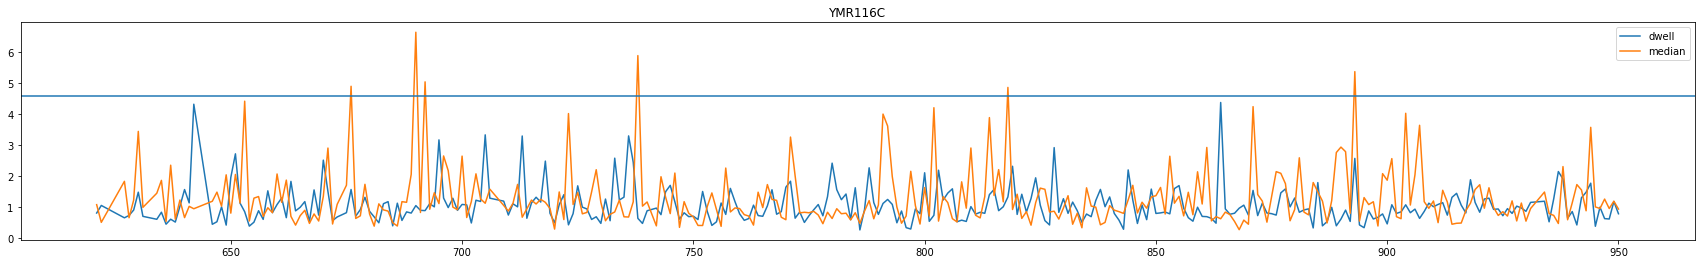

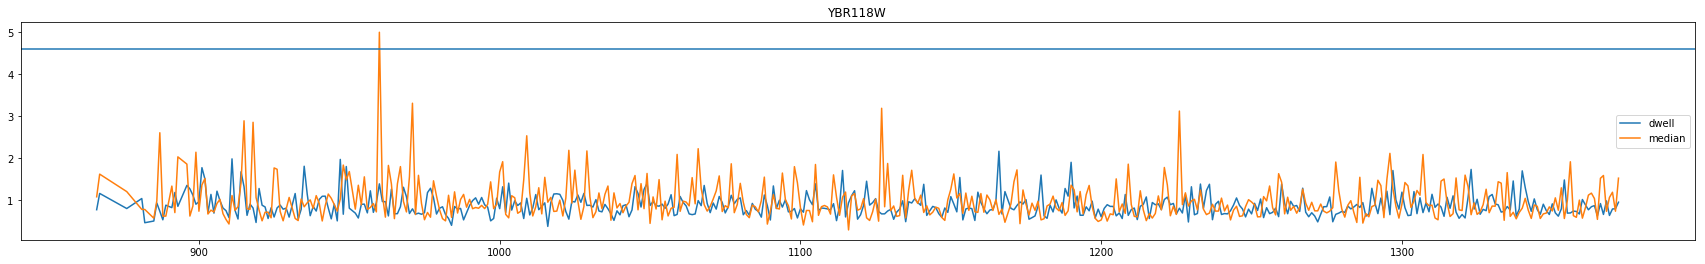

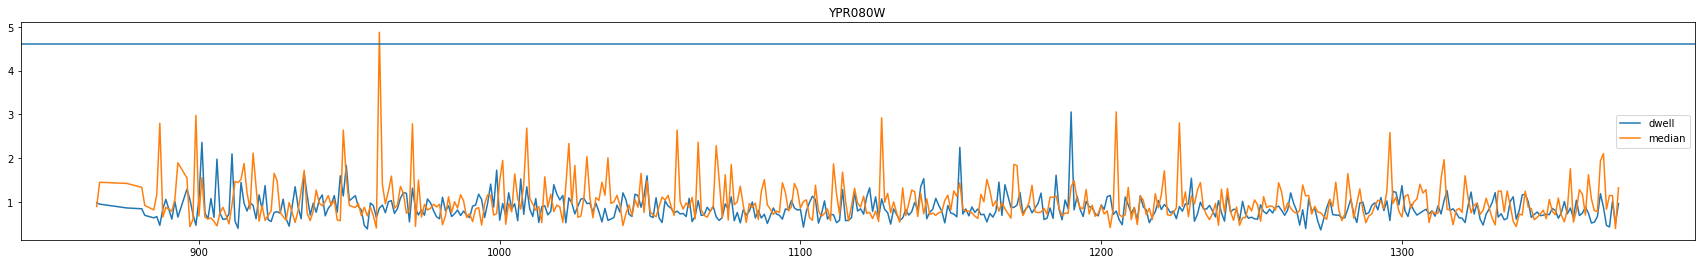

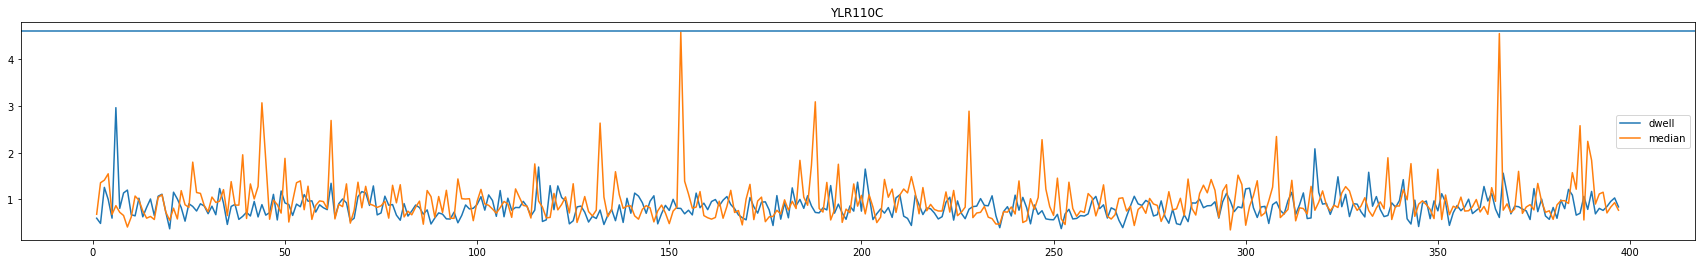

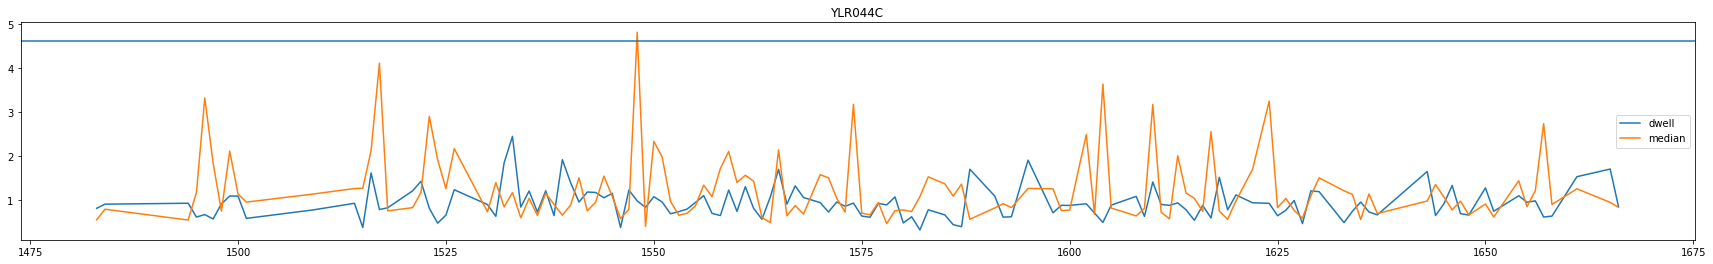

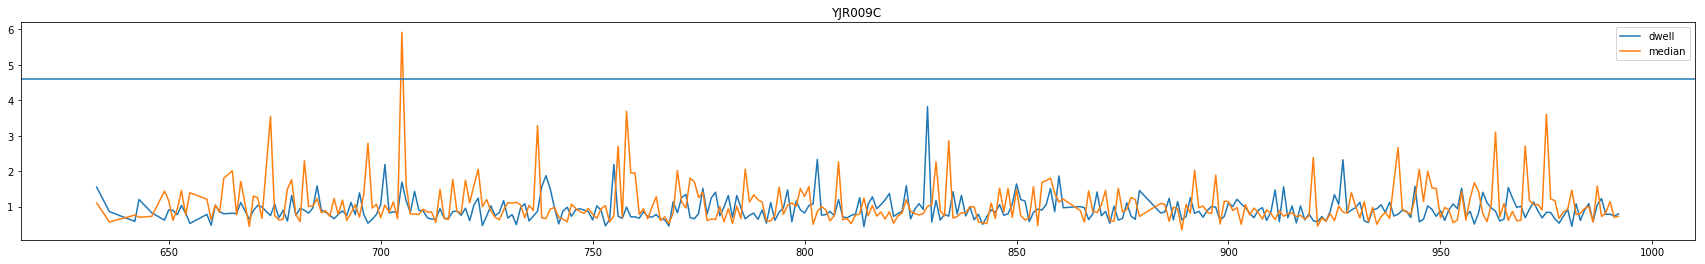

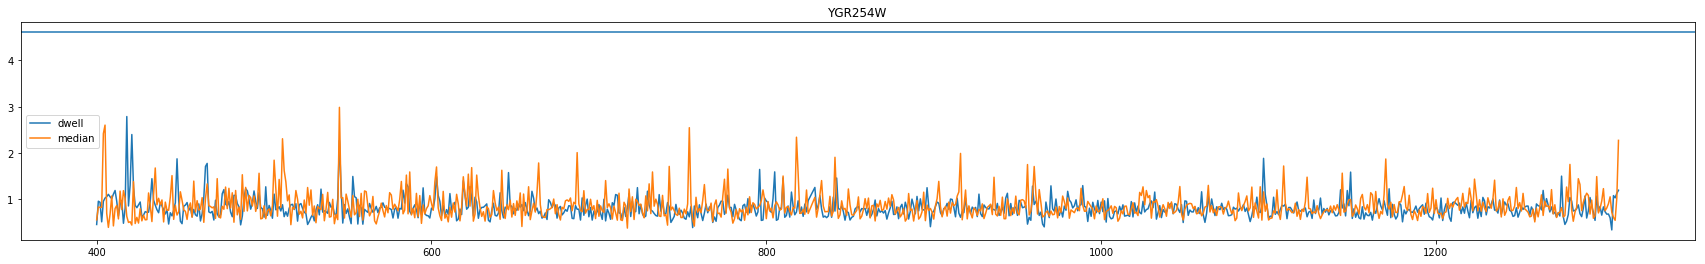

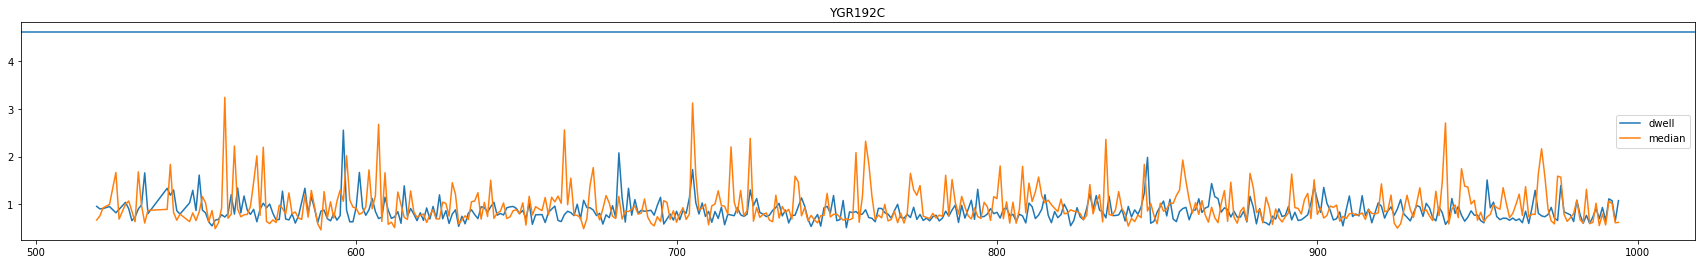

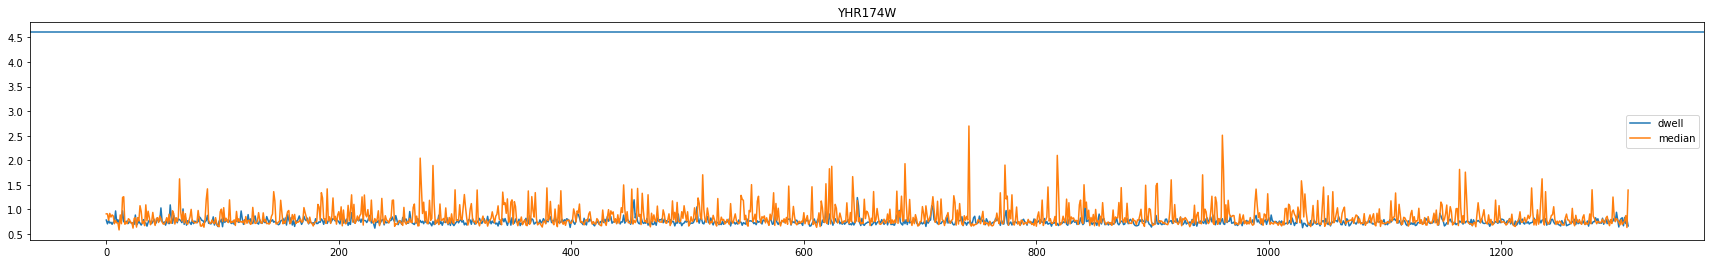

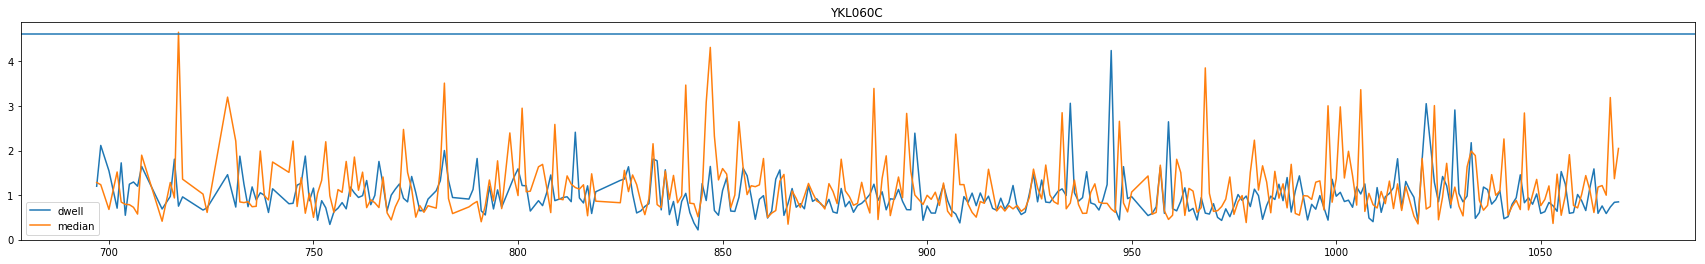

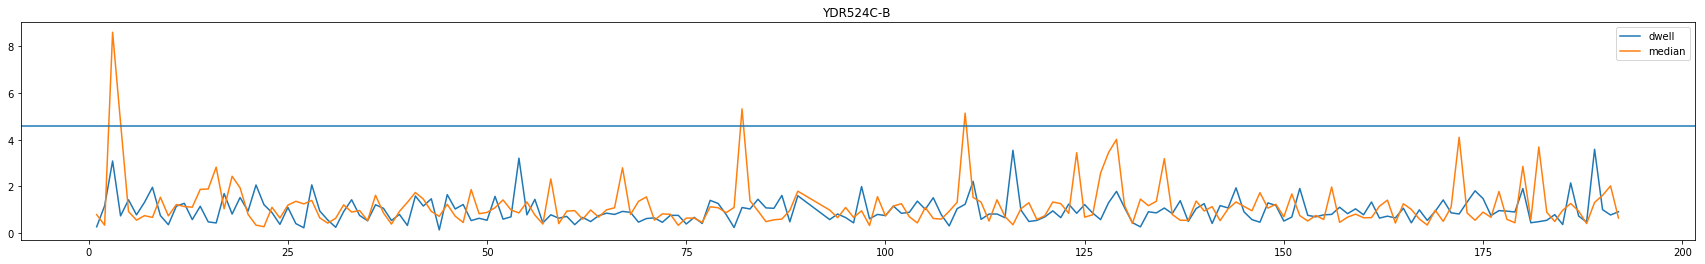

In [5]:
lim = -np.log(0.01)

for ref_id, res_dict in s:
    stdout_print (ref_id)
    fig, ax = pl.subplots (figsize=(30,4))
    df = -np.log (pd.DataFrame(res_dict)).transpose()
    _ = df.plot (ax=ax)
    _ = ax.axhline (lim)
    _ = ax.set_title (ref_id)